In [ ]:
!pip install -q tflite-model-maker

In [ ]:
import os
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')

import matplotlib.pyplot as plt
import tflite_model_maker
from glob import glob
from PIL import Image, ImageOps

In [3]:
def thumbnail(image=None, desired_size=None):
    """Resizes original image as close as possible to desired size.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    w, h = desired_size
    try:
        # convert from numpy to native Python int type
        # that PIL expects
        if isinstance(w, np.generic):
            w = w.item()
            w = int(w)
            h = h.item()
            h = int(h)
        thumb.thumbnail((w, h))
    except Exception as e:
        msg = (f"Exception in "
                f"PIL.image.thumbnail(desired_size={desired_size}):"
                f"type(width)={type(w)}, type(height)={type(h)}"
                f"\n{e}"
                )
        
        raise RuntimeError(msg)
    
    return thumb


def resize(image=None, desired_size=None):
    """Pad original image to exact size expected by input tensor.
    Preserve aspect ratio to avoid confusing the AI model with
    unnatural distortions.
    """
    assert image
    assert desired_size
    
    thumb = image.copy()
    delta_w = desired_size[0] - thumb.size[0]
    delta_h = desired_size[1] - thumb.size[1]
    padding = (0, 0, delta_w, delta_h)
    new_im = ImageOps.expand(thumb, padding)
    
    assert new_im.size == desired_size
    return new_im

In [4]:
interpreter = tf.lite.Interpreter(model_path="ai_models/tflite-model-maker-falldetect-model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
width, height = 224, 224
input_shape

array([  1, 224, 224,   3])

In [5]:
def prediction(path_image):

    template_image_src = Image.open(path_image)    
        
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
    img = resize(image=_thumbnail, desired_size=(width, height))
    
    img = np.expand_dims(img,0)
    
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred = "fall" if np.argmax(output_data[0])==0 else "no-fall"
    
    return pred

# Prediction on Single Image

In [6]:
path_image = "Images/fall_img_8.png"
pred = prediction(path_image)
pred

'fall'

# Prediction on Multiple Image

In [7]:
def pred_for_dir(image_list):
    
    image_list = os.listdir('Images/')
        
    frame_to_display = len(image_list) 
    columns = 6
    rows = (frame_to_display // columns) + 1
    
    fig = plt.figure(figsize=(20, 28))

    plt_cnt = 1

    for i in image_list:

        image = Image.open('Images/'+i)
        pred = prediction('Images/'+i)
                
        fig.add_subplot(rows, columns, plt_cnt)
        plt.axis("off")
        
        plt_title = pred

        plt.title(plt_title)        
        plt.imshow(image)

        plt_cnt += 1

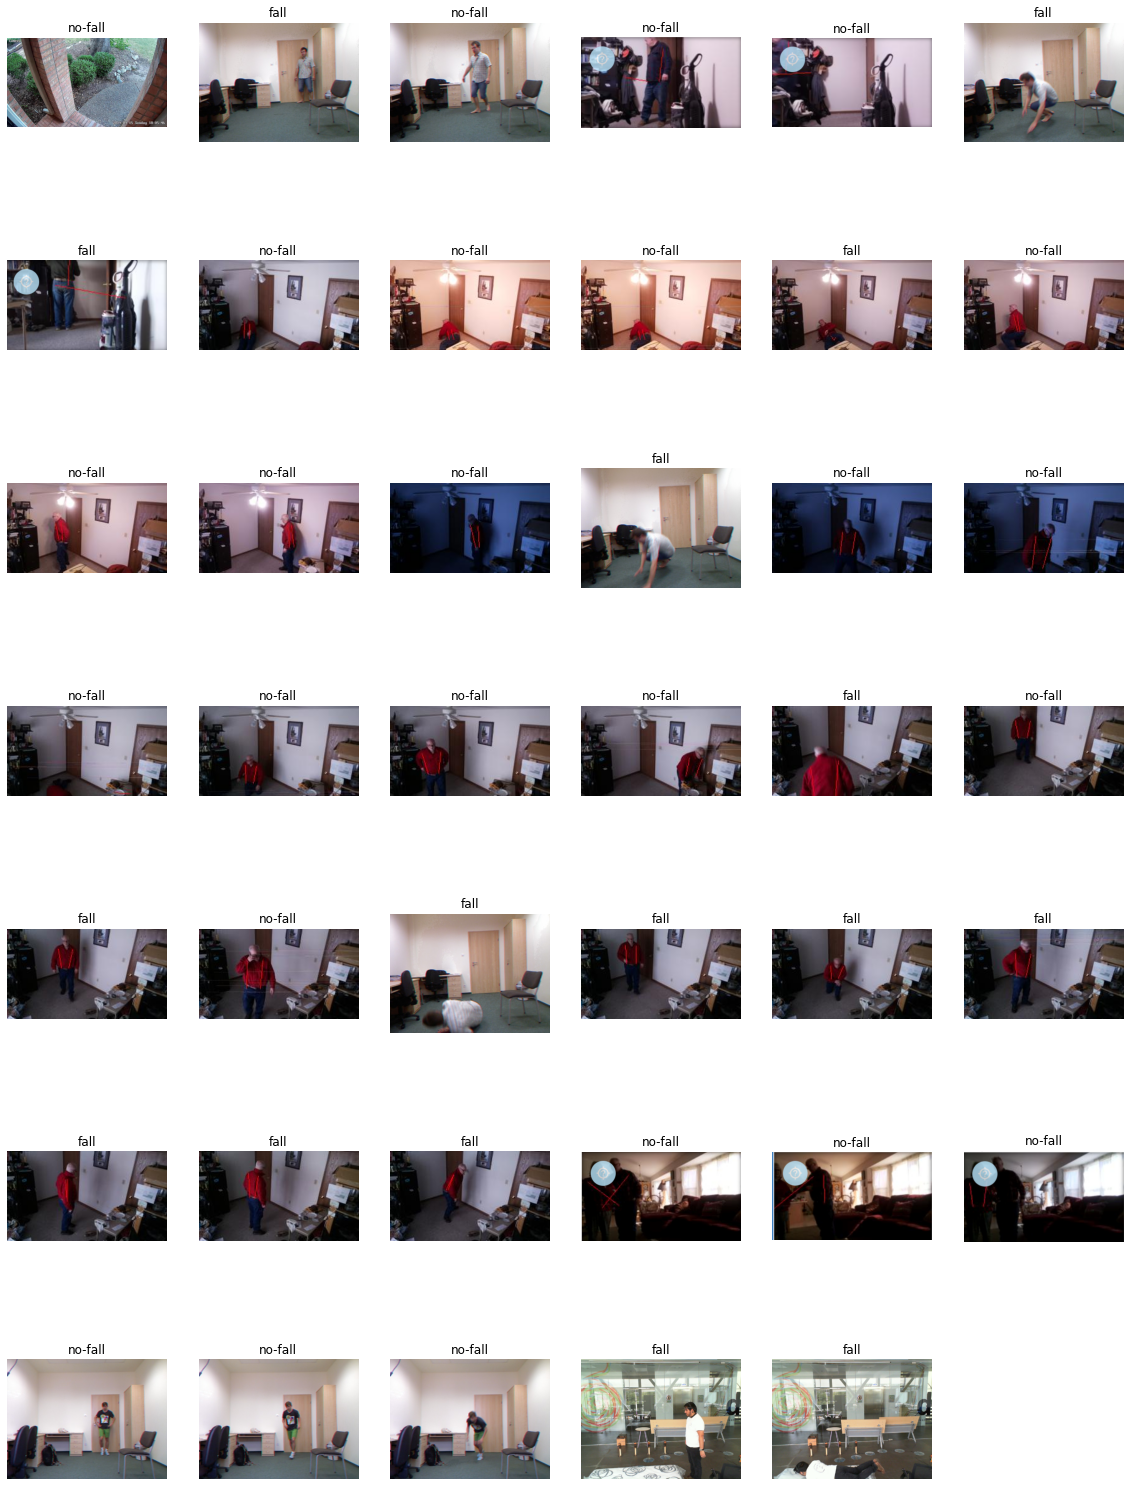

In [23]:
pred_for_dir('Images/')

# Prediction using URL

In [1]:
import requests
from io import BytesIO

In [ ]:
def predict_from_url(url):

    response = requests.get(url)
    template_image_src = Image.open(BytesIO(response.content))
    
    _thumbnail = thumbnail(image=template_image_src, desired_size=(width, height))
    img = resize(image=_thumbnail, desired_size=(width, height))
    img = np.expand_dims(img,0)
    
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred = "fall" if np.argmax(output_data[0])==0 else "no-fall"
    plt.title(pred)
    plt.imshow(template_image_src)
    
    return pred

predict_from_url(input('Enter URL->'))